# 4. Assignment overview
---------

### Part 1 - Mandatory
**Develop a challenger model:** \
Using the concepts from **Session 7** and **Session 8**, create a challenger model to compare against the `model` and `model_2` built in **Session 5**. Name your new model `model_3`. 

> Explore various **architectures, models, activation functions, and other hyperparameters to improve performance**.

> Experiment with different combinations of **optimizers, loss functions, and metrics** to evaluate how they affect training speed, overall performance, and the final model's accuracy. This will help you fine-tune your model for the specific problem you're addressing.

> Add at least one additional hidden layer. Observe how this affects the model's performance and overfitting and make note of the differences.


### Set up

In [228]:
python_material_folder_name = "python-material"

#### Import libraries

In [230]:
#Import library
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Check if in Google Colab environment
try:
    from google.colab import drive
    # Mount drive
    drive.mount('/content/drive')
    # Set up path to Python material parent folder
    path_python_material = rf"drive/MyDrive/{python_material_folder_name}"
        # If unsure, print current directory path by executing the following in a new cell:
        # !pwd
    IN_COLAB = True
except:
    IN_COLAB = False
    # If working locally on Jupyter Notebook, parent folder is one folder up (assuming you are using the folder structure shared at the beginning of the course)
    path_python_material = "/Users/hisay/Desktop/Courses/DSFinance/Data_Science_in_Finance_Resources/python-material"

# Read data that was exported from previous session
df = pd.read_csv(f"{path_python_material}/data/1-raw/lending-club-2007-2020Q3/Loan_status_2007-2020Q3-100ksample.csv")
df.head()

# #Read the dictionary file
# df_dictionary = pd.read_excel(f"{path_python_material}/data/1-raw/lending-club-2007-2020Q3/LCDataDictionary.xlsx")

# # Convert to Markdown format
# from IPython.display import Markdown
# markdown_table = df_dictionary.to_markdown(index=False)  
#print("\n Here is the Dictionary for the list of the variables \n")
#display(Markdown(markdown_table))  # Display as Markdown 

,Unnamed: 0.1,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
0,1746494,25450,167338079,4000.00,4000.00,4000.00,36 months,13.08%,134.93,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
1,2370717,81861,71016917,24000.00,24000.00,24000.00,60 months,9.16%,500.07,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
2,2264870,397109,39589826,5000.00,5000.00,5000.00,36 months,10.49%,162.49,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
3,595422,15492,134798709,24000.00,24000.00,24000.00,60 months,11.05%,522.42,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
4,562657,90591,127097355,14000.00,14000.00,14000.00,60 months,13.59%,322.79,C,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N


### 1. Data preprocessing

Based on the previous exploratory data analysis, we choose the following numerical features -- 

```X = ['installment', 'revol_bal', 'recoveries', 'collection_recovery_fee','last_fico_range_high', 'last_fico_range_low', 'tot_cur_bal','open_acc_6m', 'open_il_24m', 'total_bal_il', 'inq_fi','acc_open_past_24mths', 'bc_util', 'mo_sin_old_il_acct','percent_bc_gt_75', 'total_il_high_credit_limit', 'annual_inc', "loan_amnt"]```

    ```
    y = "loan_status"
    ```
*We would like to build the model that identifies the borrowers who are least likely to default.*

#### **Feautre selection**

In [232]:
#Lets add the new column named "loan_default"
df = df.copy()
df["loan_default"] = df["loan_status"] == "Charged Off"
df['term_numeric'] = df['term'].str.extract(r'(\d+)').astype(int)
df['int_rate_numeric'] = df['int_rate'].str.extract(r'(\d+)').astype(int)

# Creating a new feature: 1. Debt to income ratio
df['debt_to_income'] = df['loan_amnt'] / df['annual_inc']
# Creating a new feature: 2. interest received for a given loan
df['interest_per_loan_amnt'] =  df['loan_amnt']* df['int_rate_numeric'] * df['term_numeric']/100 
# Creating a new feature: 3. Fico ratio
df["fico_score"] = (df["fico_range_high"] + df["fico_range_low"])/ (2) #add the column named fico_score
df.head() 

,Unnamed: 0.1,Unnamed: 0,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,loan_default,term_numeric,int_rate_numeric,debt_to_income,interest_per_loan_amnt,fico_score
0,1746494,25450,167338079,4000.00,4000.00,4000.00,36 months,13.08%,134.93,B,...,NaN,NaN,NaN,N,False,36,13,0.08,18720.00,667.00
1,2370717,81861,71016917,24000.00,24000.00,24000.00,60 months,9.16%,500.07,B,...,NaN,NaN,NaN,N,False,60,9,0.42,129600.00,682.00
2,2264870,397109,39589826,5000.00,5000.00,5000.00,36 months,10.49%,162.49,B,...,NaN,NaN,NaN,N,False,36,10,0.09,18000.00,667.00
3,595422,15492,134798709,24000.00,24000.00,24000.00,60 months,11.05%,522.42,B,...,NaN,NaN,NaN,N,False,60,11,0.55,158400.00,752.00
4,562657,90591,127097355,14000.00,14000.00,14000.00,60 months,13.59%,322.79,C,...,NaN,NaN,NaN,N,False,60,13,0.29,109200.00,737.00


In [233]:
df["debt_to_income"] = df["debt_to_income"].replace(np.inf, 999)
def check_infinity(df):
    infinite_list = df.isin([-np.inf, np.inf]).sum()

    if infinite_list.sum() == 0:
        print("No column has infinite values")
    else:
        print("Columns with infinite values:")
        print(infinite_list[infinite_list>0])
check_infinity(df)

No column has infinite values


In [234]:
# Let's use the same features used by the model previously built, plus the categorical ones
features = ['installment', 'revol_bal', 'recoveries', 'collection_recovery_fee',
       'last_fico_range_high', 'last_fico_range_low', 'tot_cur_bal',
       'open_acc_6m', 'open_il_24m', 'total_bal_il', 'inq_fi',
       'acc_open_past_24mths', 'bc_util', 'mo_sin_old_il_acct',
       'percent_bc_gt_75', 'total_il_high_credit_limit', 'annual_inc',
            "loan_amnt", "int_rate_numeric", "term_numeric",
                   "fico_range_low", "fico_range_high", "interest_per_loan_amnt",
            "fico_score", "debt_to_income" ]

X = df[features]
y = df['loan_default']

print(f"Number of features: {len(features)}")

Number of features: 25


**1.a Drop the rows with NAN**

In [236]:
X = X.copy()
X = X.dropna(axis = 0)
y = y.loc[X.index]


**1.b** ``Performing min-max scaling`` over the training dataests such that given feautres have mean of 0 and the statndard devaition of 1.0.

In [238]:
from sklearn.preprocessing import MinMaxScaler
# Apply Min-Max Scaling (alternative: StandardScaler for z-score normalization)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame with same column names
X_scaled_df = pd.DataFrame(X_scaled, columns=features)
X_scaled_df.head()

,installment,revol_bal,recoveries,collection_recovery_fee,last_fico_range_high,last_fico_range_low,tot_cur_bal,open_acc_6m,open_il_24m,total_bal_il,...,total_il_high_credit_limit,annual_inc,loan_amnt,int_rate_numeric,term_numeric,fico_range_low,fico_range_high,interest_per_loan_amnt,fico_score,debt_to_income
0,0.28,0.02,0.00,0.00,0.83,0.83,0.02,0.00,0.11,0.04,...,0.05,0.01,0.59,0.16,1.00,0.11,0.11,0.18,0.11,0.00
1,0.29,0.01,0.00,0.00,0.88,0.88,0.03,0.15,0.04,0.01,...,0.02,0.00,0.59,0.24,1.00,0.49,0.48,0.22,0.49,0.00
2,0.17,0.01,0.00,0.00,0.92,0.92,0.02,0.15,0.04,0.02,...,0.04,0.00,0.33,0.32,1.00,0.41,0.40,0.15,0.40,0.00
3,0.40,0.00,0.00,0.00,0.83,0.83,0.02,0.08,0.14,0.07,...,0.07,0.01,0.47,0.48,0.00,0.03,0.03,0.16,0.03,0.00
4,0.16,0.00,0.00,0.00,0.91,0.91,0.04,0.00,0.07,0.01,...,0.01,0.00,0.20,0.24,0.00,0.70,0.70,0.05,0.70,0.00


### 2. Building a baseline model


In [240]:
# Split the data into training and testing sets (returns pandas dfs)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, 
                                                    y, test_size=0.3, random_state=123)

In [241]:
#Import the necessary classes and function
from keras.models import Sequential
from keras.layers import Input, Dense

def create_baseline():
    """
    Initializes and compiles a baseline neural network for binary classification.
      
    Returns:
      Compiled baseline model.
    """
    # Determine input dimension from the pre-scaled dataframe
    input_dim = X_scaled_df.shape[1]
    
    # Build the model using a list of layers
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(18, activation='relu'),
        Dense(8, activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model with the Adam optimizer, binary crossentropy loss,
    # and several performance metrics.
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall', 'AUC']
    )
    
    return model

In [242]:
#Plot training and validation accuracy to detect overfitting
def plot_training_vs_overfitting(history):
    """Plot training and validation accuracy to detect overfitting (when gap between 2 is detected)"""
    
    import matplotlib.pyplot as plt

    # Plot accuracy
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.grid(False)
    plt.tight_layout()
    
    plt.show()

    # Plot loss
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.grid(False)
    plt.tight_layout()
    
    plt.show()

Final Training Accuracy: 0.9738683104515076


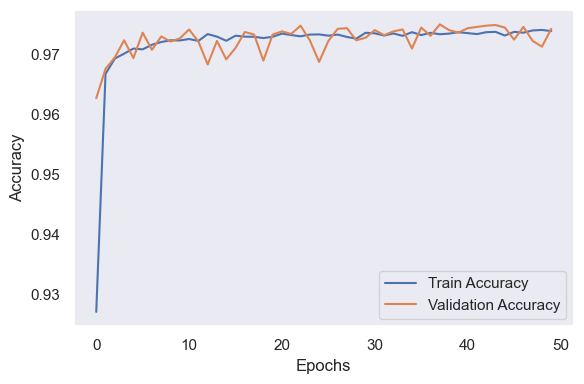

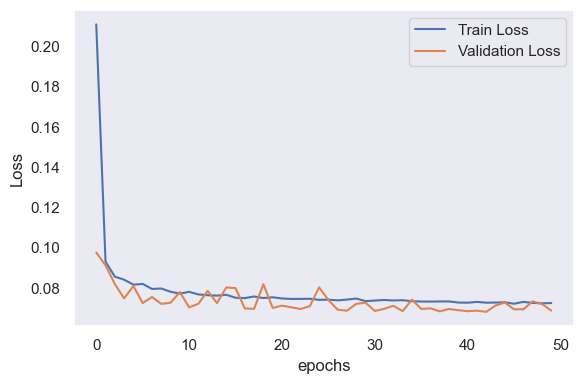

In [243]:
# Build the model using your defined function
model = create_baseline() 
# Train the model on the training set with 
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_split=0.2, verbose = 0 )
print("Final Training Accuracy:", history.history['accuracy'][-1])
plot_training_vs_overfitting(history)

From the above figure, plotting the accuracy it's apparent that after 8 epochs, the validation and the training accuracy nearly overlap.

In [245]:
# Make predictions
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5)

632/632 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [246]:
from dsif6utility import model_evaluation_report
print("Display the model performance report:")
print("-----")
model_evaluation_report(X_test, y_test, y_pred, y_prob)

Display the model performance report:
-----
Accuracy: 0.9729395468487188
Precision: 0.940959409594096
Recall: 0.7723372034326098
F1-Score: 0.8483504297199889
ROC-AUC: 0.9820950817995551
Confusion Matrix:
[[18137    96]
 [  451  1530]]


### 3. Building an alternate model

We create a new model to improve the model predictive performance. In this model we perform L2 regularization.

Final Training Accuracy: 0.9609880447387695


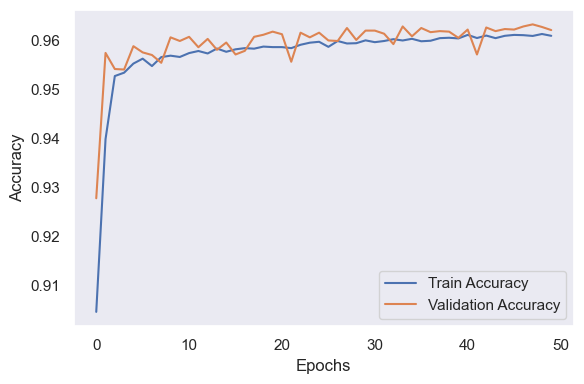

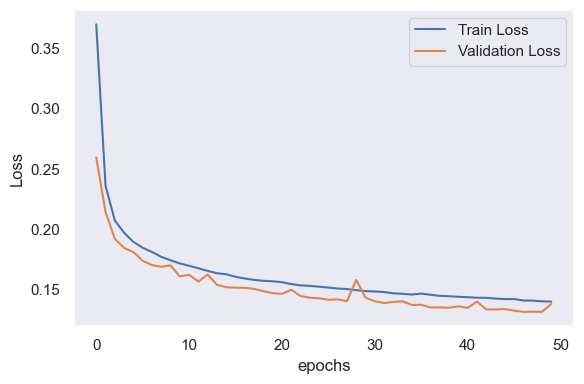

In [248]:
def create_alternate_model():
    """
    Initializes and compiles a neural network for binary classification.
    
    Returns:
      Compiled  alternate model.
    """
    from keras.models import Sequential
    from keras.layers import Input, Dense
    from keras.regularizers import l2
    
    # Determine input dimension from the pre-scaled dataframe
    input_dim = X_scaled_df.shape[1]
    
    # Build the model using a list of layers
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(18, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
        Dense(1, activation='sigmoid')
    ]) 
    # Compile the model with the Adam optimizer, binary crossentropy loss,
    # and several performance metrics.
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'Precision', 'Recall', 'AUC']
    )
    return model
    
# Build the model using your defined function
model = create_alternate_model()
# Train the model on the training set with 
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose = 0 )
print("Final Training Accuracy:", history.history['accuracy'][-1])
plot_training_vs_overfitting(history)

In [249]:
# Make predictions
y_prob = model.predict(X_test)
y_pred = (y_prob > 0.5)

from dsif6utility import model_evaluation_report
print("Display the model performance report:")
print("-----")
model_evaluation_report(X_test, y_test, y_pred, y_prob)

632/632 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Display the model performance report:
-----
Accuracy: 0.9641832393390719
Precision: 0.8182278481012658
Recall: 0.8157496214033316
F1-Score: 0.8169868554095046
ROC-AUC: 0.9760490108783955
Confusion Matrix:
[[17874   359]
 [  365  1616]]


An alternate model shows improved predictive accuracy, with the accuracy versus epochs plot indicating strong alignment between training and cross-validation performance, and an ROC value approaching 0.97 (97%).

In [251]:
#Import the saved model from the Assignment-2 (XGB classifier)
import joblib
filename = 'joblib_model_XGB.sav'
baseline_model = joblib.load(filename)

# evaluate model 
y_prob = baseline_model.predict(X_test)
y_pred = (y_prob > 0.5)

# check results
model_evaluation_report(X_test, y_test, y_pred, y_prob)

Accuracy: 0.9032848520827149
Precision: 1.0
Recall: 0.013124684502776375
F1-Score: 0.025909317389138018
ROC-AUC: 0.5065623422513882
Confusion Matrix:
[[18233     0]
 [ 1955    26]]


**Notes**

In my view, the model is performing well for the given features. To me it appears that we can enhance the performance by performing feature engineering and selecting the few most important features from the datasets. 